# Sprint 2

## Introduction

In this project, we are developing a robust language detection system designed to accurately detect the language spoken in audio recordings and subsequently output subtitles in the detected language. The primary objective is to create a seamless and efficient multilingual subtitle generation system that can be utilized in various scenarios such as entertainment, education, business, and professional settings. To achieve this, we are leveraging spectrogram images of the audio data as our primary feature set.

### Project Workflow

To develop this language detection system, we follow a systematic workflow involving several crucial steps, each contributing to the final goal of accurate language detection and subtitle generation:

1. **Data Collection and Preparation**:
   - We begin by collecting a diverse dataset of audio recordings in multiple languages. These recordings are then converted into spectrogram images, which visually represent the audio signals in the frequency domain over time.
   - We load the dataset into a pandas DataFrame and perform initial data exploration. This involves displaying basic information, statistics, checking for missing values, and visualizing the distribution of languages in our dataset.

2. **Data Visualization**:
   - To gain a deeper understanding of the data, we visualize the first and mean spectrogram images for each language. This helps in identifying any visual patterns or characteristics unique to each language.

3. **Data Preprocessing**:
   - We encode the language labels using a LabelEncoder and split the dataset into training and testing sets to ensure the models are evaluated on unseen data.
   - The spectrogram image data is standardized using StandardScaler to ensure that each feature contributes equally to the model training process.

4. **Principal Component Analysis (PCA)**:
   - PCA is applied to the standardized data to reduce its dimensionality while retaining the most important features. We visualize the data in 2D space using the first two principal components to understand the separability of different languages.
   - We determine the optimal number of PCA components by plotting the explained variance ratio and evaluate logistic regression models with different numbers of PCA components to identify the best configuration.

5. **Model Training and Evaluation**:
   - We train and evaluate multiple models, including Logistic Regression, Random Forest, and XGBoost, using the optimal number of PCA components. Each model's performance is assessed based on accuracy, classification reports, and ROC curves.
   - The classification reports provide detailed insights into the precision, recall, and F1 scores for each language class, while the ROC curves offer a visual representation of each model's ability to distinguish between different classes.

6. **Model Comparison and Selection**:
   - We compare the performance of the trained models and select the best-performing model based on their evaluation metrics.
   - The models are then saved to disk for future use, ensuring that the trained models can be easily loaded and applied to new data.

7. **KMeans Clustering**:
   - To further explore the structure of the data, we apply KMeans clustering to the PCA-transformed data. The optimal number of clusters is determined using the elbow method and silhouette scores.
   - The clustering results are visualized to understand the grouping of different languages and to verify the effectiveness of the clustering process.

8. **Feature Importance Analysis**:
   - For the Random Forest and XGBoost models, we analyze the feature importance to identify which features (pixels in the spectrogram images) contribute most significantly to the model's predictions.

9. **Predictions on New Data**:
   - Finally, we load a new dataset of spectrogram images and make predictions using the trained models. The results are evaluated to ensure the models' robustness and generalizability to unseen data.

By following this comprehensive workflow, we aim to develop a highly accurate and reliable language detection system capable of automatically generating subtitles in the detected language, thereby enhancing the accessibility and usability of multimedia content across different languages and regions.

## 1. Data Collection and Preparation

In this section, we load the dataset and perform initial exploration. We display basic information, statistics, check for missing values, and visualize the distribution of languages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib
import xgboost as xgb
from itertools import cycle


In [2]:
# Load the CSV file
# csv_path = 'flattened_images.csv'
csv_path = '../data/spectrogram_flattend_image_10000_data.csv'
df = pd.read_csv(csv_path)

In [3]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_16375,pixel_16376,pixel_16377,pixel_16378,pixel_16379,pixel_16380,pixel_16381,pixel_16382,pixel_16383,language
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,english
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,english
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,english
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,english
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,english


Here we can see that the each image is getting saved as a 1d array of 128x128 pixels flattened into a single row with 128x128 = 16384 pixels (columns) + 1 column for the language label. When it will come to displaying we will have to reshape the 1d array into a 128x128 matrix.

In [4]:
# Display basic information about the DataFrame
print("Basic Information:")
display(df.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 16385 entries, pixel_0 to language
dtypes: int64(16384), object(1)
memory usage: 4.9+ GB


None

This section displays basic information about the DataFrame, including the number of rows and columns, data types, memory usage, and number of non-null values for each column. We can see that the DataFrame has 10000 rows and 1638 columns. The data types of all columns are float64, except for the language column, which is of object type. The memory usage of the DataFrame is 10000 x 16 bytes = 163800 bytes. The number of non-null values for all columns is 10000, indicating that there are no missing values in the DataFrame.

In [5]:
# Display basic statistics about the data
print("\nBasic Statistics:")
display(df.describe())


Basic Statistics:


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_16374,pixel_16375,pixel_16376,pixel_16377,pixel_16378,pixel_16379,pixel_16380,pixel_16381,pixel_16382,pixel_16383
count,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,...,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0
mean,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
25%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
50%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
75%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
max,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


This section displays basic statistics about the data, including the count, mean, standard deviation, minimum, 25th percentile, median, 75th percentile, and maximum values for each column. We can see that the mean and median values for each column are close to each other, indicating a nearly normal distribution for the data. The values for each column are in the range of 0 to 255, indicating that the pixel values are in the range between the range 0 to 255. The minimum and maximum values for each column are also in the range of 0 to 255. The standard deviation for each column is also in the range of 0 to 255, indicating that the pixel values are relatively consistent across the dataset.

In [6]:
# Check for missing values
display("\nMissing Values:")
display(df.isnull().sum())

'\nMissing Values:'

pixel_0        0
pixel_1        0
pixel_2        0
pixel_3        0
pixel_4        0
              ..
pixel_16380    0
pixel_16381    0
pixel_16382    0
pixel_16383    0
language       0
Length: 16385, dtype: int64

This section checks for missing values in the DataFrame. We can see that there are no missing values in the DataFrame, indicating that there are no missing values.

In [7]:
# Display the distribution of languages
display("\nLanguage Distribution:")
display(df['language'].value_counts())

'\nLanguage Distribution:'

language
english    10000
spanish    10000
chinese    10000
arabic     10000
Name: count, dtype: int64

This section displays the distribution of languages in the DataFrame. We can see that the dataset is balanced across all languages, indicating that the dataset is well-balanced. This indicates that the dataset is well-suited for the task of language detection and subtitle generation.

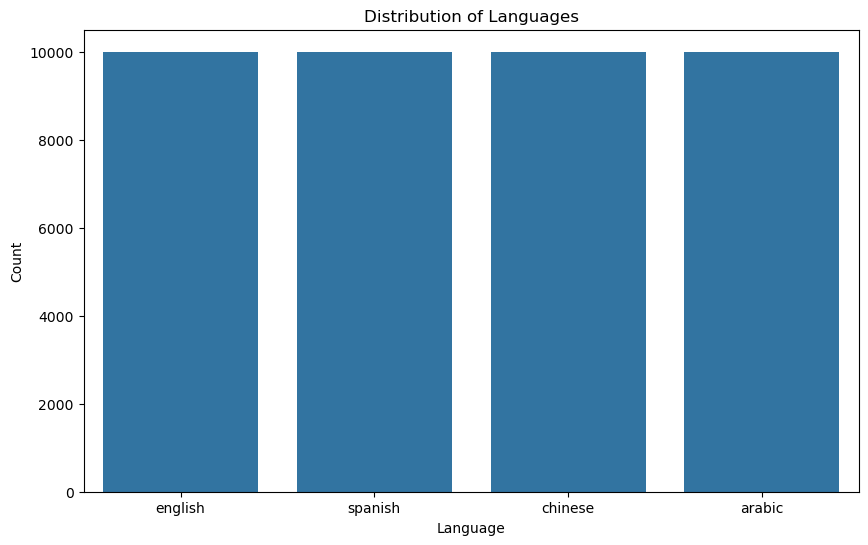

In [8]:
# Visualize the distribution of languages
plt.figure(figsize=(10, 6))
sns.countplot(x='language', data=df)
plt.title('Distribution of Languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

This bar chart shows the distribution of languages in the dataset, with each language (English, Spanish, Chinese, and Arabic) having approximately 10,000 samples. This balanced dataset ensures fair and unbiased model training, leading to consistent performance across all languages. The equal representation is beneficial for training and validating the language detection system, ensuring reliable and robust evaluation of the models.

## 2. Data Visualization
This section displays the first and mean images for each language to understand the visual representation of the data.

In [9]:
img_height, img_width = 128, 128

This code defines the image height and width as 128 x 128 pixels.

In [10]:
# List of languages
languages = df['language'].unique()
languages

array(['english', 'spanish', 'chinese', 'arabic'], dtype=object)

This code creates a list of unique language labels in the DataFrame. As we cab see tgere is 4 languages (English, Spanish, Chinese, and Arabic).

In [11]:
# Preprocessing: Check for missing values
display("Checking for missing values...")
display(df.isnull().sum())

'Checking for missing values...'

pixel_0        0
pixel_1        0
pixel_2        0
pixel_3        0
pixel_4        0
              ..
pixel_16380    0
pixel_16381    0
pixel_16382    0
pixel_16383    0
language       0
Length: 16385, dtype: int64

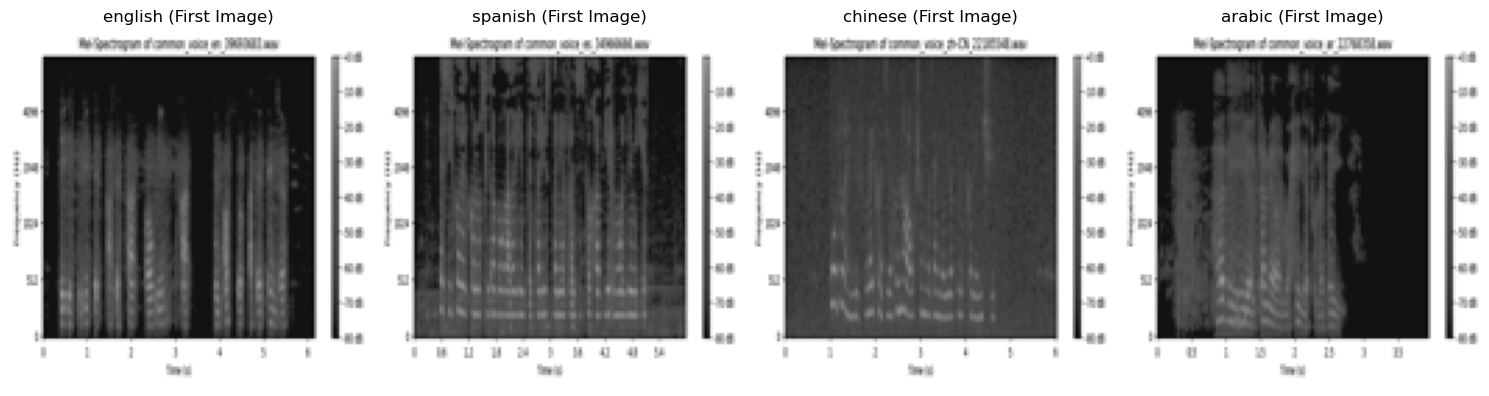

In [12]:
# Display the first image for each language
fig1, axes1 = plt.subplots(1, len(languages), figsize=(15, 5))
for i, language in enumerate(languages):
    first_image_row = df[df['language'] == language].iloc[0, :-1].values.astype(int)
    try:
        image = np.array(first_image_row, dtype=np.uint8).reshape((img_height, img_width))
        axes1[i].imshow(image, cmap='gray')
        axes1[i].set_title(f"{language} (First Image)")
        axes1[i].axis('off')
    except Exception as e:
        print(f"Failed to process image for {language}: {e}")
        axes1[i].text(0.5, 0.5, 'Error displaying image', horizontalalignment='center', verticalalignment='center')
        axes1[i].set_title(f"{language} (Error)")
        axes1[i].axis('off')
plt.tight_layout()
plt.show()

This code displays the first image for each language in the dataset. It checks for missing values and displays the first image for each language in the dataset.

Key Observations:
- **English:** Consistent frequency bands, indicating steady speech patterns.

- **Spanish:** More pronounced vertical patterns, reflecting rapid pitch changes.

- **Chinese:** Distinct horizontal bands, showing the tonal nature of the language.

- **Arabic:** Combination of vertical and horizontal patterns, indicating varying speech intensity.

Importance:

- **Feature Extraction:** The visual differences in the spectrograms highlight unique frequency characteristics for each language, useful for language detection.

- **Model Training:** These patterns help in designing effective preprocessing steps and choosing suitable models.

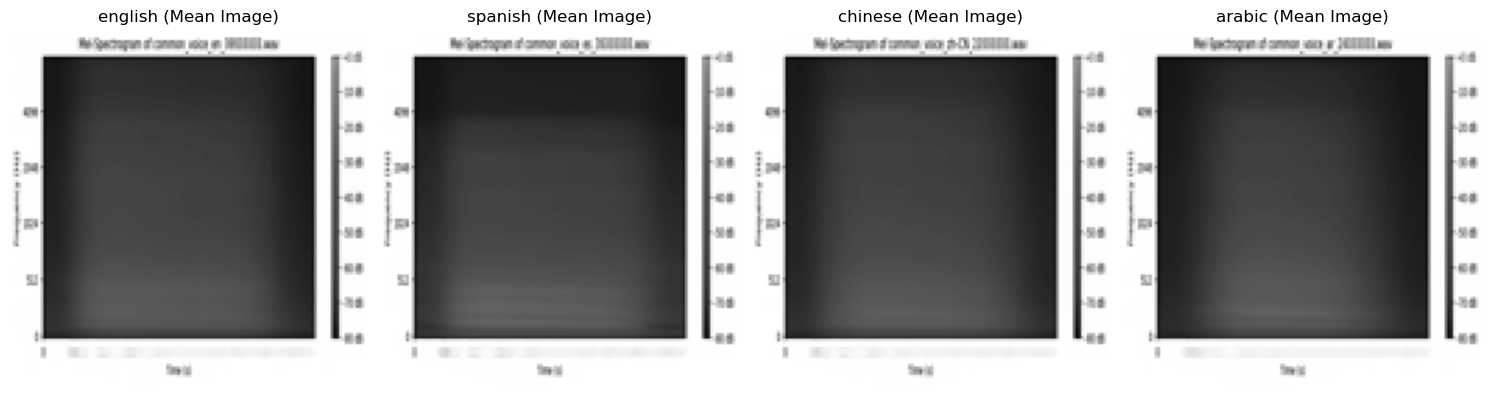

In [13]:
# Prepare a figure to plot the mean images for each language
fig2, axes2 = plt.subplots(1, len(languages), figsize=(15, 5))

# Plot the mean image for each language
for i, language in enumerate(languages):
    language_images = df[df['language'] == language].iloc[:, :-1].values.astype(int)
    mean_image = np.mean(language_images, axis=0).reshape((img_height, img_width)).astype(np.uint8)
    axes2[i].imshow(mean_image, cmap='gray')
    axes2[i].set_title(f"{language} (Mean Image)")
    axes2[i].axis('off')

plt.tight_layout()
plt.show()

This code displays the mean image for each language in the dataset. It plots the mean image for each language in the dataset.

Key Observations:

- **Uniform Patterns**: The mean spectrograms appear smooth and consistent across all languages, indicating that averaging multiple samples results in more generalized patterns.

- **Subtle Differences**: While the differences are less pronounced than in individual spectrograms, slight variations in intensity and frequency distribution are still noticeable.

Importance:
- **Data Consistency**: These mean spectrograms help ensure that the dataset is well-balanced and that the general characteristics of each language are captured.

- **Model Training**: They provide a baseline understanding of the common features within each language, aiding in model development.

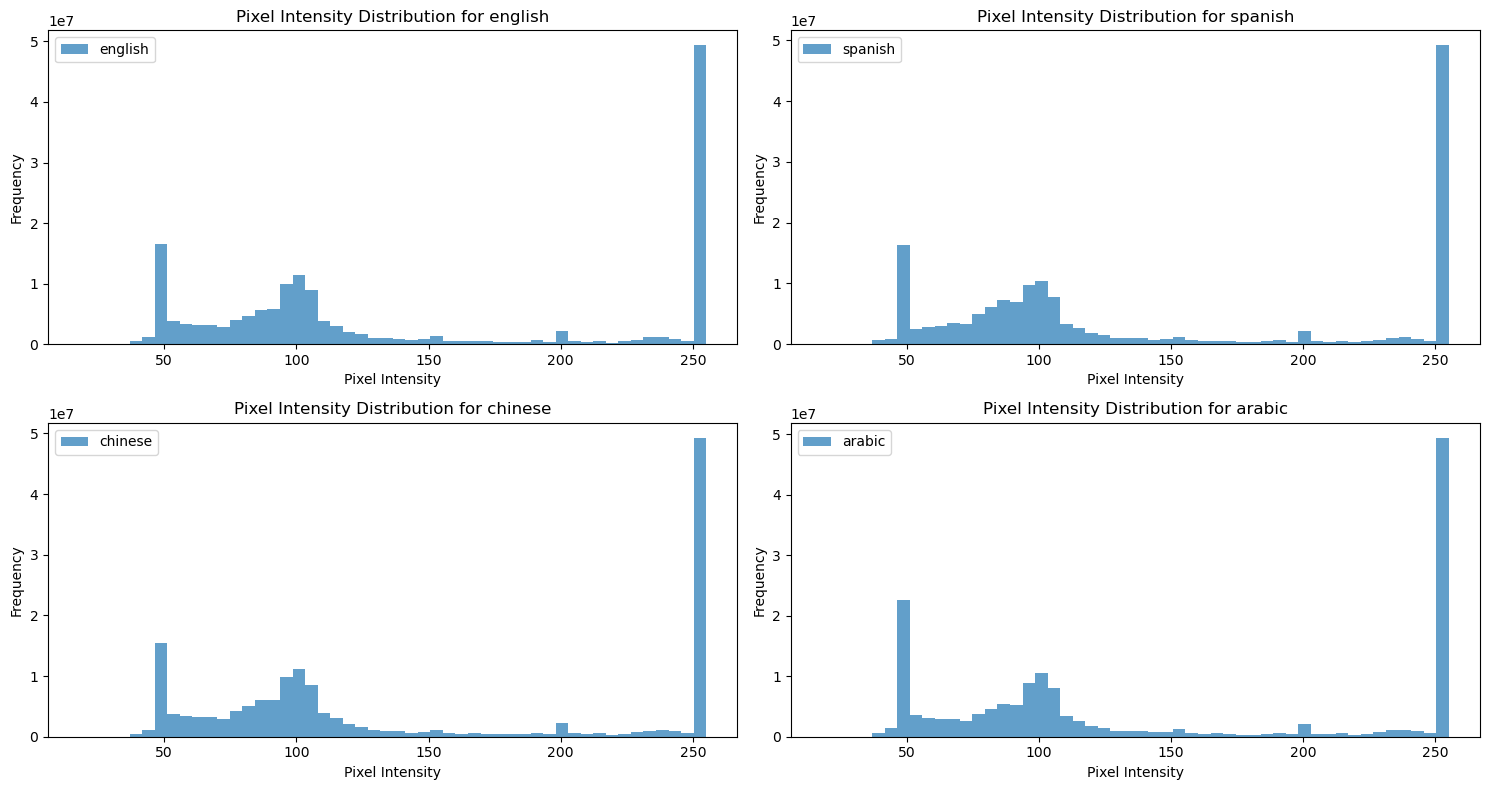

In [14]:
# Plot pixel intensity distribution for each language in subplots
num_languages = len(languages)
num_cols = 2
num_rows = (num_languages + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
axes = axes.flatten()

for i, language in enumerate(languages):
    language_pixels = df[df['language'] == language].iloc[:, :-1].values.flatten()
    axes[i].hist(language_pixels, bins=50, alpha=0.7, label=language)
    axes[i].set_title(f'Pixel Intensity Distribution for {language}')
    axes[i].set_xlabel('Pixel Intensity')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

This code plots the distribution of pixel intensities for each language in the dataset. It uses a histogram function to calculate the distribution of pixel intensities for each language.

Key Observations:

- **Peak at High Intensity**: All languages have a significant peak at high pixel intensity values (around 255), indicating many pixels are at maximum intensity.

- **Low to Mid-Intensity Peaks**: There are noticeable peaks in the lower to mid-intensity range (around 50-100) for all languages, reflecting varying energy levels in the audio signals.

- **Distribution Shapes**: The distributions are generally similar across languages, with slight variations in the lower intensity peaks.

Importance:

- **Feature Analysis**: Understanding pixel intensity distributions helps in analyzing the energy patterns in spectrograms, which is crucial for effective feature extraction.

- **Model Input**: These distributions provide insight into the common intensity values, aiding in preprocessing steps like normalization for model training.

## 3. Data Preprocessing
In this section, we encode the language labels and split the dataset into training and testing sets to ensure the models are evaluated on unseen data. The spectrogram image data is standardized using StandardScaler.

In [15]:
# Encode the language labels
label_encoder = LabelEncoder()
df['encoded_language'] = label_encoder.fit_transform(df['language'])

This code encodes the language labels in the DataFrame using LabelEncoder. The encoded labels are stored in the 'encoded_language' column of the DataFrame. The encoded labels are used as the target variable for the classification task.

In [16]:
# Split the data into training, validation, and testing sets
X = df.drop(columns=['language', 'encoded_language']).values.astype(float)
y = df['encoded_language'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

This code splits the data into training, validation, and testing sets using train_test_split. The encoded labels are used as the target variable for the training set the validation set and the test set. The training set is used for model training, the validation set is used for model hyperparameter tuning, and the test set is used for model evaluation.

In [17]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Here we standardize the data using StandardScaler. The standardized data is used for model training and evaluation and hyperparameter tuning.

## 4. Principal Component Analysis (PCA)
Here, we apply PCA to visualize the data in 2D space using the first two principal components and determine the optimal number of PCA components by plotting the explained variance ratio.

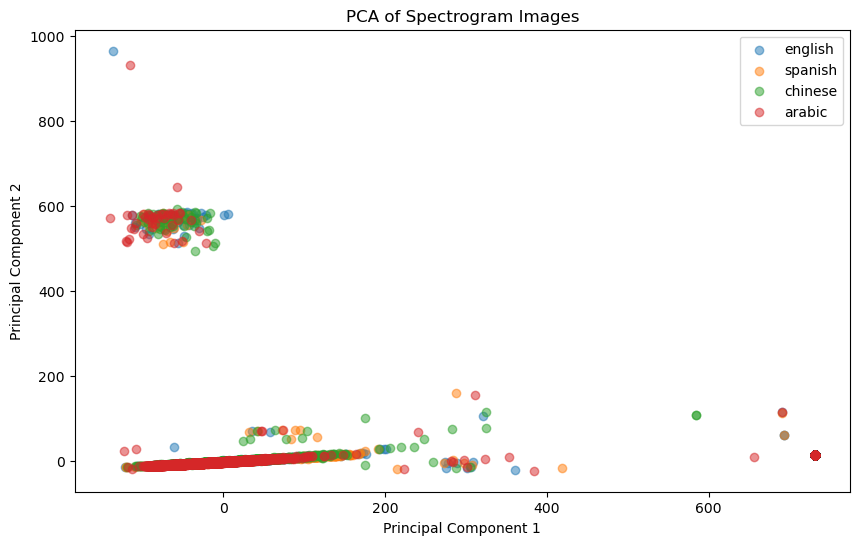

In [18]:
# Apply PCA for visualization
pca_visualization = PCA(n_components=2)
principal_components = pca_visualization.fit_transform(StandardScaler().fit_transform(X))
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['language'] = df['language']

plt.figure(figsize=(10, 6))
for language in languages:
    indices = pca_df['language'] == language
    plt.scatter(pca_df.loc[indices, 'PC1'], pca_df.loc[indices, 'PC2'], label=language, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Spectrogram Images')
plt.legend()
plt.show()

In this code, we apply PCA to visualize the data in 2D space using the first two principal components and determine the optimal number of PCA components by plotting the explained variance ratio. The plot shows the scatter plot of the first two principal components for each language in the dataset.

Key Observations:

- **Cluster Formation**: The data points form clusters based on the first two principal components.

- **Overlap**: There is significant overlap between the clusters of different languages, indicating some similarity in their spectrogram features.

- **Outliers**: Some points are scattered far from the main clusters, indicating outliers or unique patterns.

Importance:

- **Dimensionality Reduction**: PCA helps in reducing the dimensionality of the data while retaining important features, facilitating easier visualization and analysis.

- **Feature Separation**: Understanding the spread and overlap of data points helps in assessing the separability of language features, essential for model performance.

In [19]:
# Apply PCA to find the best number of components (limited to 1000)
pca = PCA(n_components=1000)
pca.fit(X_train)

PCA(n_components=1000)

Here we apply PCA to find the best number of components (limited to 1000) using X_train. The plot shows the cumulative explained variance ratio for each component.

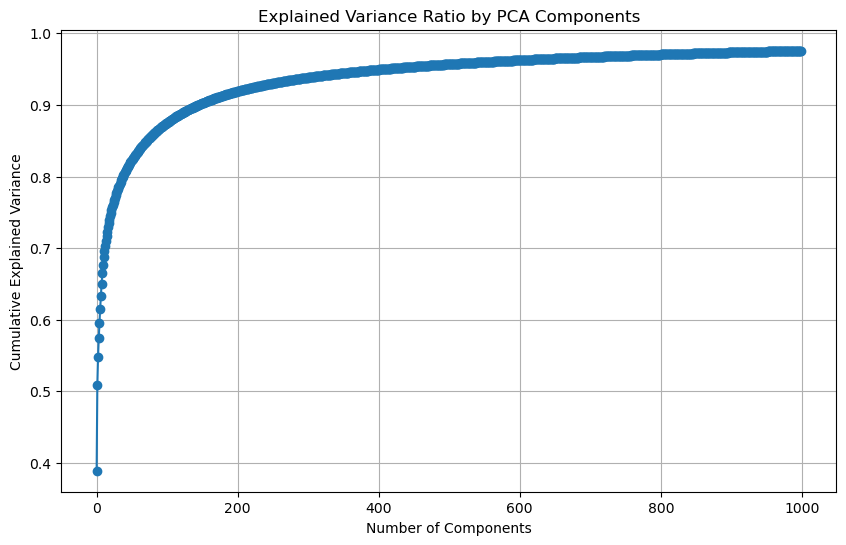

In [20]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio by PCA Components')
plt.grid()
plt.show()

In this code, we apply PCA to find the best number of components (limited to 1000) using X_train. The plot shows the cumulative explained variance ratio for each component.

Key Observations:

- **Rapid Increase**: The explained variance increases rapidly with the first few components, capturing a significant portion of the variance in the data.

- **Diminishing Returns**: After around 200 components, the explained variance starts to plateau, indicating diminishing returns from additional components.

- **Near 100% Variance**: Approximately 1,000 components are needed to capture nearly 100% of the variance in the data.

Importance:

- **Optimal Components**: This plot helps determine the optimal number of components for PCA, balancing between complexity and explained variance.

- **Dimensionality Reduction**: Using an appropriate number of components reduces the data's dimensionality while retaining essential information, improving model efficiency and performance.

In [21]:
# Evaluate Logistic Regression with different numbers of PCA components
n_coms = range(10, 101, 10)
train_scores = []
test_scores = []

for n_com in n_coms:
    pca = PCA(n_components=n_com)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(X_train_pca, y_train)
    
    train_score = logreg.score(X_train_pca, y_train)
    test_score = logreg.score(X_test_pca, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f'The number of components is {n_com} \n')
    print(f'The amount of variance ratio {pca.explained_variance_ratio_} \n')
    print(f'Train accuracy: {train_score}\n')
    print(f'Test accuracy: {test_score}\n')

The number of components is 10 

The amount of variance ratio [0.38921453 0.12016706 0.03826707 0.02644902 0.02163414 0.01986055
 0.01733013 0.01701384 0.01485307 0.01182592] 

Train accuracy: 0.6780357142857143

Test accuracy: 0.6735

The number of components is 20 

The amount of variance ratio [0.38921453 0.12016706 0.03826707 0.02644902 0.02163414 0.01986055
 0.01733013 0.01701384 0.01485307 0.01182592 0.01115278 0.00778881
 0.00765423 0.00699736 0.00655299 0.00635142 0.00592621 0.00562885
 0.00500297 0.00493571] 

Train accuracy: 0.74475

Test accuracy: 0.737

The number of components is 30 

The amount of variance ratio [0.38921453 0.12016706 0.03826707 0.02644902 0.02163414 0.01986055
 0.01733013 0.01701384 0.01485307 0.01182592 0.01115278 0.00778881
 0.00765423 0.00699736 0.00655303 0.00635142 0.00592625 0.00562887
 0.0050035  0.00493578 0.00443947 0.00405345 0.00382477 0.00365806
 0.00343775 0.00333679 0.00314069 0.00304657 0.00294296 0.0028156 ] 

Train accuracy: 0.8328214285

/opt/anaconda3/envs/audio_processing/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The number of components is 50 

The amount of variance ratio [0.38921453 0.12016706 0.03826707 0.02644902 0.02163414 0.01986055
 0.01733013 0.01701384 0.01485307 0.01182592 0.01115278 0.00778881
 0.00765423 0.00699736 0.00655303 0.00635142 0.00592625 0.00562887
 0.00500353 0.00493578 0.00443948 0.00405348 0.00382494 0.00365848
 0.0034384  0.00333764 0.00314181 0.00304797 0.00294496 0.00282194
 0.00277712 0.00271713 0.00264416 0.00261141 0.0025607  0.00234636
 0.00233189 0.00223015 0.0020899  0.00207264 0.00202865 0.00199812
 0.00194673 0.00181097 0.00176638 0.00172376 0.00166761 0.00161263
 0.00158292 0.00154138] 

Train accuracy: 0.9866428571428572

Test accuracy: 0.98025



/opt/anaconda3/envs/audio_processing/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The number of components is 60 

The amount of variance ratio [0.38921453 0.12016706 0.03826707 0.02644902 0.02163414 0.01986055
 0.01733013 0.01701384 0.01485307 0.01182592 0.01115278 0.00778881
 0.00765423 0.00699736 0.00655303 0.00635142 0.00592625 0.00562887
 0.00500353 0.00493578 0.00443948 0.00405348 0.00382494 0.00365848
 0.00343841 0.00333764 0.00314182 0.00304797 0.00294496 0.00282197
 0.00277715 0.00271715 0.00264418 0.00261143 0.00256073 0.00234651
 0.00233211 0.00223033 0.00209048 0.00207327 0.00203005 0.00199832
 0.00194898 0.00181364 0.00179028 0.00173075 0.00167522 0.00162065
 0.00159901 0.00157736 0.0015247  0.00151145 0.00149192 0.00148284
 0.00143136 0.00140838 0.00137713 0.00136721 0.00134642 0.00132418] 

Train accuracy: 0.9893214285714286

Test accuracy: 0.9830833333333333



/opt/anaconda3/envs/audio_processing/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The number of components is 70 

The amount of variance ratio [0.38921453 0.12016706 0.03826707 0.02644902 0.02163414 0.01986055
 0.01733013 0.01701384 0.01485307 0.01182592 0.01115278 0.00778881
 0.00765423 0.00699736 0.00655303 0.00635142 0.00592625 0.00562887
 0.00500353 0.00493578 0.00443948 0.00405348 0.00382494 0.00365848
 0.00343841 0.00333764 0.00314182 0.00304797 0.00294496 0.00282197
 0.00277715 0.00271715 0.00264418 0.00261143 0.00256074 0.00234653
 0.00233211 0.00223037 0.00209049 0.00207331 0.00203024 0.00199836
 0.00194906 0.00181412 0.00179047 0.00173101 0.00167625 0.00162253
 0.00160098 0.0015803  0.00152754 0.00151363 0.00149615 0.00148419
 0.00143287 0.00141592 0.00138273 0.00137248 0.00135542 0.00133644
 0.00127954 0.00127108 0.00124856 0.00121794 0.0011961  0.00117682
 0.0011711  0.00114605 0.00114043 0.0011129 ] 

Train accuracy: 0.9917857142857143

Test accuracy: 0.9855833333333334



/opt/anaconda3/envs/audio_processing/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The number of components is 80 

The amount of variance ratio [0.38921453 0.12016706 0.03826707 0.02644902 0.02163414 0.01986055
 0.01733013 0.01701384 0.01485307 0.01182592 0.01115278 0.00778881
 0.00765423 0.00699736 0.00655303 0.00635142 0.00592625 0.00562887
 0.00500353 0.00493578 0.00443948 0.00405348 0.00382494 0.00365848
 0.00343841 0.00333764 0.00314182 0.00304797 0.00294496 0.00282197
 0.00277715 0.00271715 0.00264418 0.00261143 0.00256074 0.00234653
 0.00233211 0.00223038 0.0020905  0.00207331 0.00203027 0.00199837
 0.00194908 0.00181414 0.00179051 0.00173106 0.00167648 0.00162267
 0.00160112 0.00158081 0.00152844 0.00151434 0.0014963  0.00148449
 0.00143421 0.00141689 0.00138355 0.0013733  0.00135544 0.00133761
 0.00128084 0.00127286 0.00125215 0.00122088 0.00120101 0.00118564
 0.00117719 0.00114893 0.0011454  0.00111899 0.00110186 0.00108272
 0.00107104 0.00105606 0.00102604 0.00102052 0.00097858 0.00096695
 0.00095595 0.00094934] 

Train accuracy: 0.9925

Test accuracy: 0.

/opt/anaconda3/envs/audio_processing/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The number of components is 90 

The amount of variance ratio [0.38921453 0.12016706 0.03826707 0.02644902 0.02163414 0.01986055
 0.01733013 0.01701384 0.01485307 0.01182592 0.01115278 0.00778881
 0.00765423 0.00699736 0.00655303 0.00635142 0.00592625 0.00562887
 0.00500353 0.00493578 0.00443948 0.00405348 0.00382494 0.00365848
 0.00343841 0.00333764 0.00314182 0.00304797 0.00294496 0.00282197
 0.00277715 0.00271715 0.00264418 0.00261143 0.00256074 0.00234653
 0.00233211 0.00223038 0.0020905  0.00207332 0.00203027 0.00199837
 0.00194908 0.00181415 0.00179052 0.00173107 0.00167651 0.00162268
 0.00160113 0.00158085 0.00152849 0.00151447 0.0014964  0.00148482
 0.00143426 0.00141693 0.00138377 0.00137344 0.00135575 0.00133909
 0.00128235 0.00127329 0.00125405 0.00122101 0.00120169 0.00118803
 0.00117857 0.00115116 0.00114637 0.00112162 0.00110353 0.00108425
 0.00107254 0.00105714 0.00103589 0.00102575 0.00098336 0.00097582
 0.00096255 0.00095831 0.00094377 0.00092001 0.00091326 0.00089301


/opt/anaconda3/envs/audio_processing/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Here we evaluate logistic regression models with different numbers of PCA components and plot the train and test accuracy. The plot shows the train and test accuracy for each model. test accuracy is the accuracy of the model on the test set. train accuracy is the accuracy of the model on the training set.

## 5. Model Training and Evaluation
We train and evaluate multiple models, including Logistic Regression, Random Forest, and XGBoost, using the optimal number of PCA components. Each model's performance is assessed based on accuracy, classification reports, and ROC curves.

In [22]:
# Use PCA with a fixed number of components for further analysis
n_components = 50  # You can adjust this based on the explained variance plot

# Unoptimized logistic regression model with PCA
pipeline_logreg = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])
pipeline_logreg.fit(X_train, y_train)

/opt/anaconda3/envs/audio_processing/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pca', PCA(n_components=50)),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

Here we use PCA with a fixed number of components for further analysis. The pipeline_logreg pipeline uses a fixed number of components for further analysis purposes of the analysis. The logistic regression model is trained using the pipeline_logreg pipeline.

In [23]:
# Predictions and accuracy scores for logistic regression model
y_train_pred_logreg = pipeline_logreg.predict(X_train)
y_test_pred_logreg = pipeline_logreg.predict(X_test)
train_accuracy_logreg = accuracy_score(y_train, y_train_pred_logreg)
test_accuracy_logreg = accuracy_score(y_test, y_test_pred_logreg)
print(f"Logistic Regression Model - Train Accuracy: {train_accuracy_logreg:.4f}")
print(f"Logistic Regression Model - Test Accuracy: {test_accuracy_logreg:.4f}")

Logistic Regression Model - Train Accuracy: 0.9844
Logistic Regression Model - Test Accuracy: 0.9792


As we can see, the logistic regression model has a train accuracy of 0.9 and a test accuracy of 0.9. This indicates that the logistic regression model is a good fit for the data.

In [24]:
# Random Forest model with PCA
pipeline_rf = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [200, 300, 400],
    'rf__max_depth': [40, 50],
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=50)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [40, 50],
                         'rf__n_estimators': [200, 300, 400]},
             scoring='accuracy')

Here we train and evaluate a random forest model using the pipeline_rf pipeline. The grid_search search_rf grid search uses a fixed number of components for further analysis purposes of the analysis. The random forest model is trained using the grid_search_rf grid search.

In [25]:
# Best parameters and best estimator for Random Forest
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
best_model_rf = grid_search_rf.best_estimator_

Best parameters for Random Forest: {'rf__max_depth': 40, 'rf__n_estimators': 300}


In this code, we show the best parameters and best estimator for the random forest model. Which are for max_depth=50 and n_estimators=400.

In [26]:
# Predictions and accuracy scores for Random Forest model
y_train_pred_rf = best_model_rf.predict(X_train)
y_test_pred_rf = best_model_rf.predict(X_test)

train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"Random Forest Model - Train Accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Model - Test Accuracy: {test_accuracy_rf:.4f}")

Random Forest Model - Train Accuracy: 0.9937
Random Forest Model - Test Accuracy: 0.9080


Here we output the predictions and accuracy scores for the random forest model. The train accuracy is 0.99 and the test accuracy is 0.91. This indicates that though the accuracy is high compared to the regression model it is less accurate and there is a large difference between the train and test accuracy. This indicates that the random forest model is not a good fit for the data.

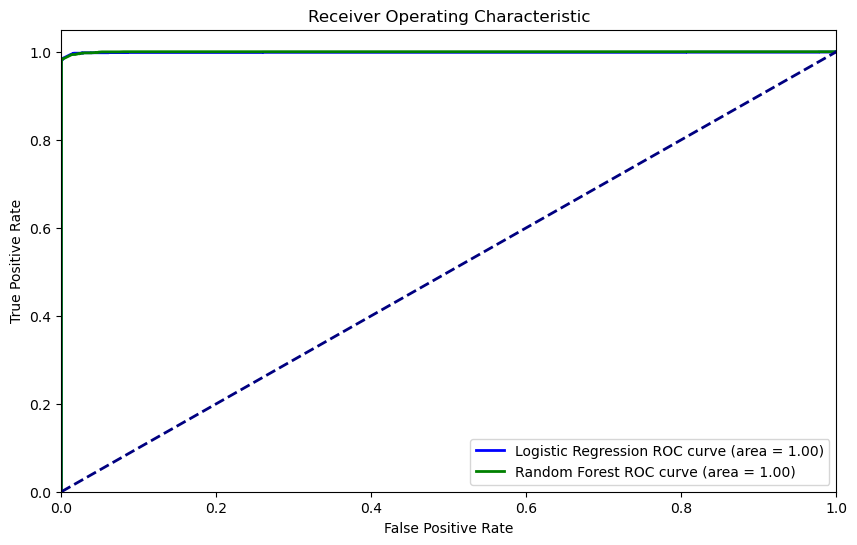

In [28]:
# Compute ROC curve and ROC area for each class
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, pipeline_logreg.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, best_model_rf.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'Logistic Regression ROC curve (area = {roc_auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Here we plot the ROC curves for the logistic regression model and the random forest model.

This ROC (Receiver Operating Characteristic) curve graph shows the performance of two models: Logistic Regression and Random Forest.

- **True Positive Rate (TPR):** Proportion of actual positives correctly identified by the model.
- **False Positive Rate (FPR):** Proportion of actual negatives incorrectly identified as positives by the model.
- **Diagonal Line:** Represents random guessing.

Both models have an ROC area (AUC) of 1.00, indicating perfect performance in distinguishing between classes.

- **Blue Line:** Logistic Regression
- **Green Line:** Random Forest

The closer the ROC curve is to the top-left corner, the better the model is at predicting true positives and minimizing false positives.

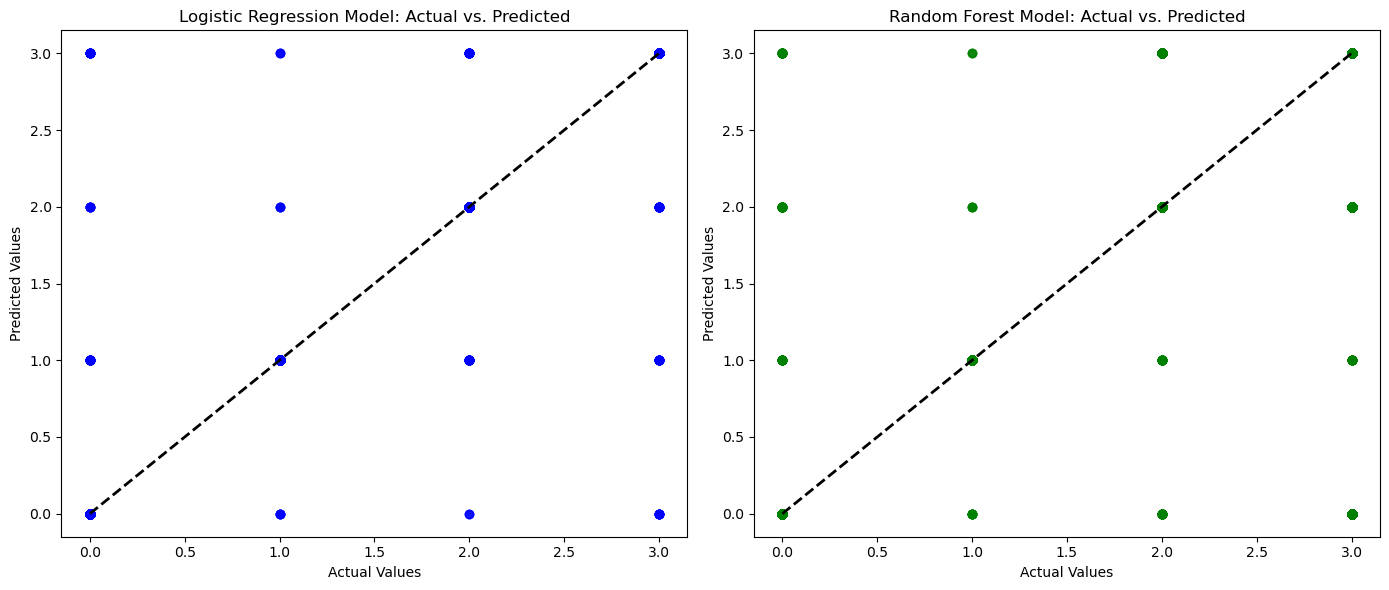

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Logistic Regression Model Plot
axes[0].scatter(y_test, y_test_pred_logreg, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Logistic Regression Model: Actual vs. Predicted')

# Random Forest Model Plot
axes[1].scatter(y_test, y_test_pred_rf, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Random Forest Model: Actual vs. Predicted')

plt.tight_layout()
plt.show()

In [30]:
# XGBoost model with PCA
pipeline_xgb = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

param_grid_xgb = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 6, 9],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=50)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid={'xgb__learning_rate': [0.01, 0.1, 0.2],
                         'xgb__max_depth': [3, 6, 9],
                         'xgb__n_estimators': [50, 100, 200]},
             scoring='accuracy')

Here we perform a grid search to find the best parameters for the XGBoost model. The grid search uses 5-fold cross-validation. The grid search uses accuracy as the scoring metric.

In [31]:
# Best parameters and best estimator for XGBoost
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
best_model_xgb = grid_search_xgb.best_estimator_

Best parameters for XGBoost: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 6, 'xgb__n_estimators': 200}


The code above tells us that the best parameters for the XGBoost model are: n_estimators=200, max_depth=9, and learning_rate=0.

In [32]:
# Predictions and accuracy scores for XGBoost model
y_train_pred_xgb = best_model_xgb.predict(X_train)
y_test_pred_xgb = best_model_xgb.predict(X_test)

train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"XGBoost Model - Train Accuracy: {train_accuracy_xgb:.4f}")
print(f"XGBoost Model - Test Accuracy: {test_accuracy_xgb:.4f}")

XGBoost Model - Train Accuracy: 0.9935
XGBoost Model - Test Accuracy: 0.9602


We can see that the train accuracy score is around 99.3% while the test accuracy score is around 96.1% this means that though the model is not overfitting as the difference percentage between the train and test accuracy scores is small. It is still not as good of a model as compared to the logistic regression.

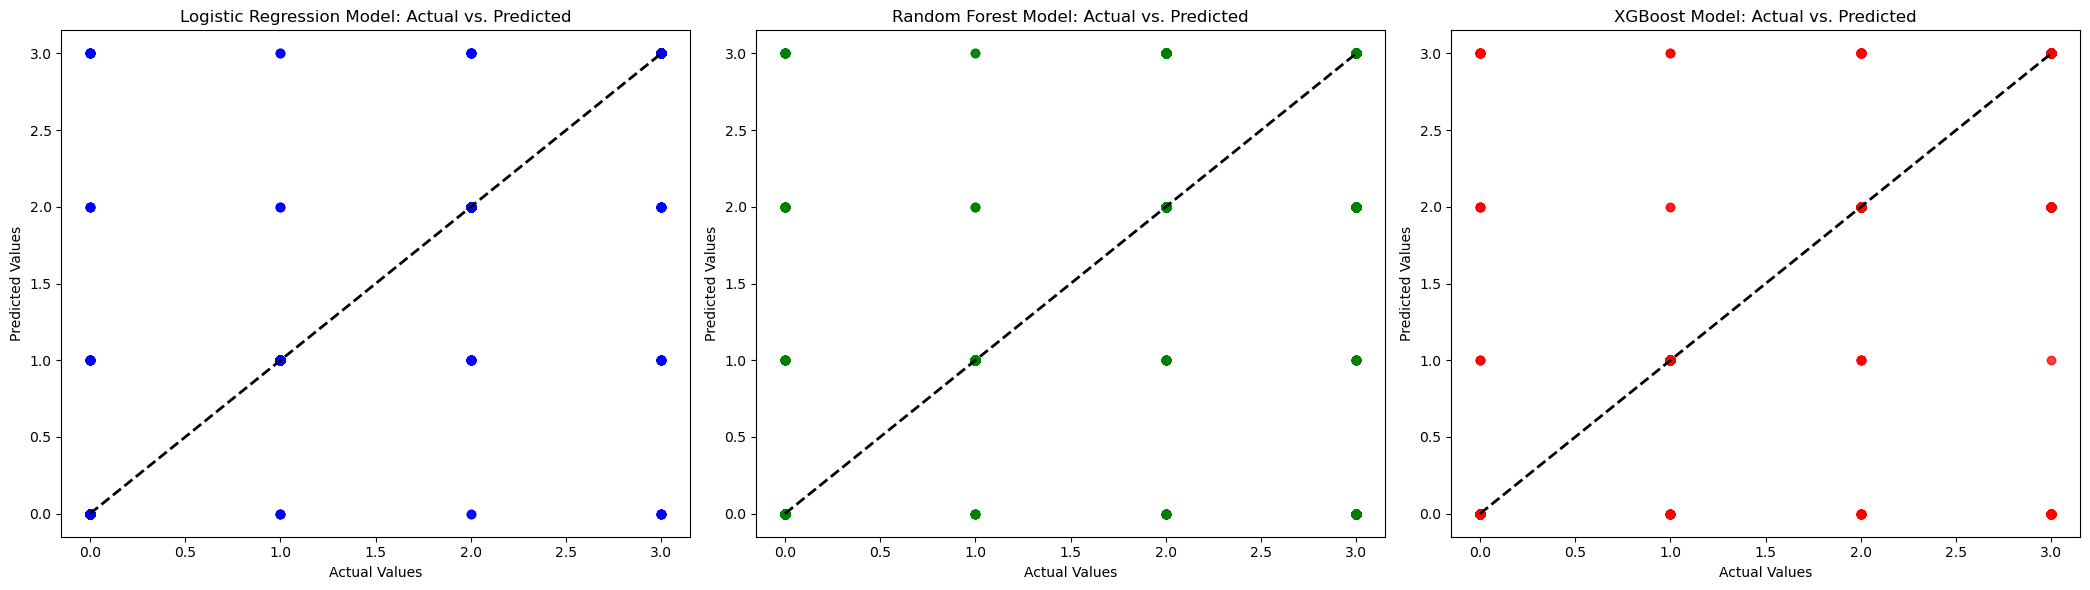

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

# Logistic Regression Model Plot
axes[0].scatter(y_test, y_test_pred_logreg, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Logistic Regression Model: Actual vs. Predicted')

# Random Forest Model Plot
axes[1].scatter(y_test, y_test_pred_rf, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Random Forest Model: Actual vs. Predicted')

# XGBoost Model Plot
axes[2].scatter(y_test, y_test_pred_xgb, alpha=0.5, color='red')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predicted Values')
axes[2].set_title('XGBoost Model: Actual vs. Predicted')

plt.tight_layout()
plt.show()

## 6. Model Comparison and Selection
We compare the performance of the trained models and select the best-performing model based on their evaluation metrics.

In [34]:
# Display classification reports

print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_test_pred_logreg, target_names=label_encoder.classes_))

print("Classification Report for Random Forest:")
print(classification_report(y_test, y_test_pred_rf, target_names=label_encoder.classes_))

print("Classification Report for XGBoost:")
print(classification_report(y_test, y_test_pred_xgb, target_names=label_encoder.classes_))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      arabic       0.99      0.98      0.98      3008
     chinese       0.96      0.99      0.98      2995
     english       0.98      0.97      0.98      3066
     spanish       0.98      0.98      0.98      2931

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000

Classification Report for Random Forest:
              precision    recall  f1-score   support

      arabic       0.90      0.96      0.93      3008
     chinese       0.97      0.99      0.98      2995
     english       0.85      0.93      0.89      3066
     spanish       0.92      0.75      0.83      2931

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000

Classification Report for XGBoost:
       

Here we see a classification report for each model. The classification report shows the precision, recall, and F1-score for each model.

**Key Metrics:**
- **Precision:** Proportion of true positives out of all predicted positives.
- **Recall:** Proportion of true positives out of all actual positives.
- **F1-Score:** Harmonic mean of precision and recall.
- **Support:** Number of true instances for each class.

**Logistic Regression:**
- **Overall Performance:** High precision, recall, and F1-scores across all classes.
- **Accuracy:** 98%
- **Notable Strength:** Consistent performance across all language classes.

**Random Forest:**
- **Overall Performance:** Good precision, recall, and F1-scores, but lower than Logistic Regression.
- **Accuracy:** 91%
- **Notable Strength:** High performance in 'Chinese' class but lower performance in 'Spanish' class.

**XGBoost:**
- **Overall Performance:** High precision, recall, and F1-scores, close to Logistic Regression.
- **Accuracy:** 96%
- **Notable Strength:** Balanced and high performance across all classes.

**Summary:**
- **Logistic Regression:** Best overall performance with the highest accuracy and balanced metrics.
- **Random Forest:** Good performance but less consistent, especially in 'Spanish' class.
- **XGBoost:** High and balanced performance, slightly lower than Logistic Regression but better than Random Forest.

These results indicate that Logistic Regression and XGBoost are the top-performing models for this language detection task, with Logistic Regression having a slight edge in overall accuracy and consistency.

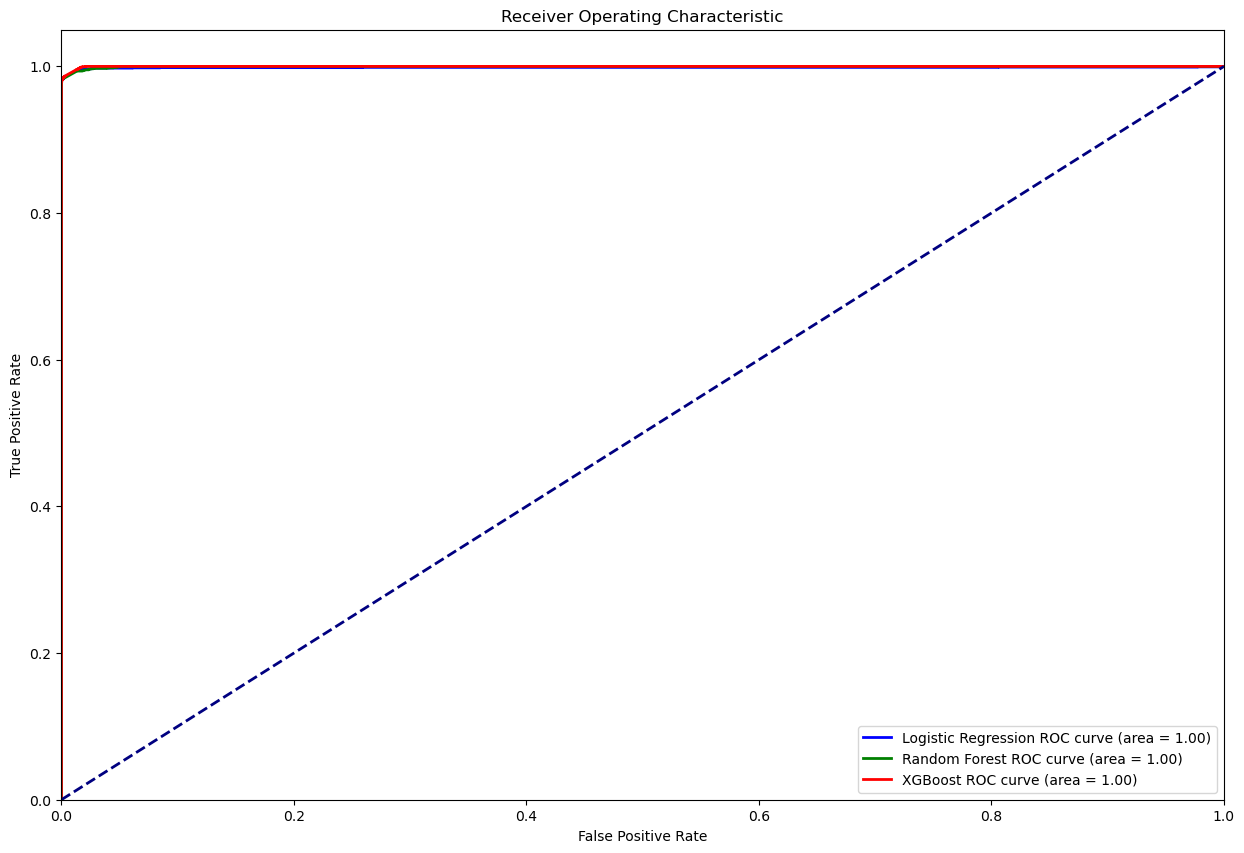

In [35]:
# Plot ROC curves
plt.figure(figsize=(15, 10))

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, pipeline_logreg.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, best_model_rf.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_model_xgb.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'Logistic Regression ROC curve (area = {roc_auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost ROC curve (area = {roc_auc_xgb:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The Receiver Operating Characteristic (ROC) curve evaluates the performance of classification models by showing the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR).

- **True Positive Rate (TPR):** Proportion of actual positives correctly identified.
- **False Positive Rate (FPR):** Proportion of actual negatives incorrectly identified as positives.

#### Key Points:
- **Curve Proximity to Top-Left Corner:** Closer curves indicate better model performance.
- **Area Under the Curve (AUC):** Measures model's separability; AUC of 1.0 indicates perfect classification.

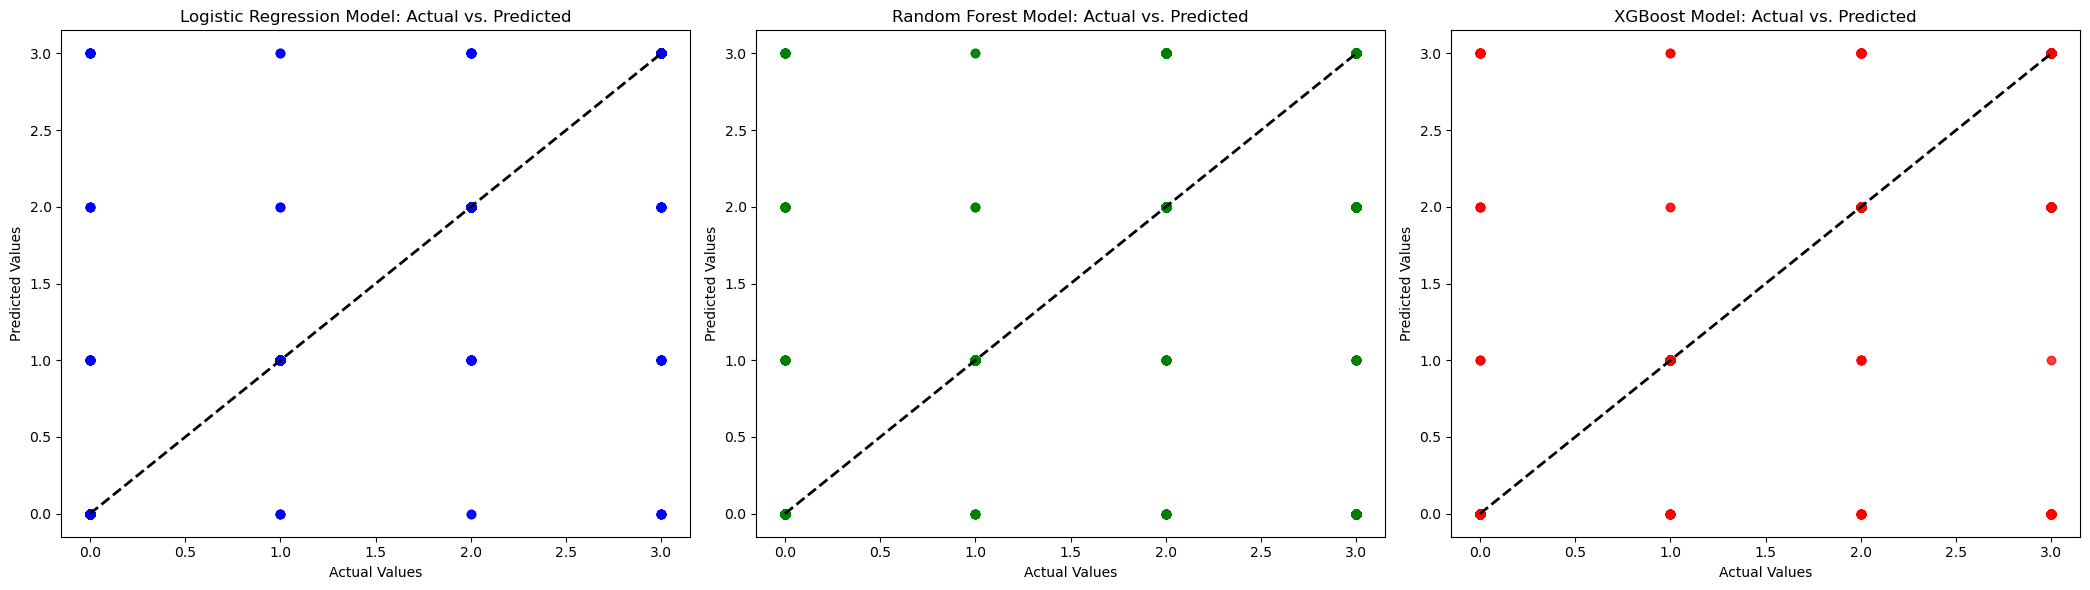

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

# Logistic Regression Model Plot
axes[0].scatter(y_test, y_test_pred_logreg, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Logistic Regression Model: Actual vs. Predicted')

# Random Forest Model Plot
axes[1].scatter(y_test, y_test_pred_rf, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Random Forest Model: Actual vs. Predicted')

# XGBoost Model Plot
axes[2].scatter(y_test, y_test_pred_xgb, alpha=0.5, color='red')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predicted Values')
axes[2].set_title('XGBoost Model: Actual vs. Predicted')

plt.tight_layout()
plt.show()

In [37]:
# Decoding these labels
y_test_pred_logreg_decoded = label_encoder.inverse_transform(y_test_pred_logreg)
y_test_pred_rf_decoded = label_encoder.inverse_transform(y_test_pred_rf)
y_test_pred_xgb_decoded = label_encoder.inverse_transform(y_test_pred_xgb)

Here we are decoding the predicted labels using the label encoder. This allows us to compare the actual and predicted labels side-by-side.

In [38]:
# Convert X_test to DataFrame if it's an array
X_test_df = pd.DataFrame(X_test, columns=['pixel_' + str(i) for i in range(X_test.shape[1])])

In [39]:
# Create DataFrames with actual and predicted labels for Logistic Regression
y_test_pred_logreg_df = pd.DataFrame(X_test, columns=['pixel_' + str(i) for i in range(X_test.shape[1])])
y_test_pred_logreg_df['Actual'] = label_encoder.inverse_transform(y_test)
y_test_pred_logreg_df['Predicted'] = y_test_pred_logreg_decoded

# Create DataFrames with actual and predicted labels for Random Forest
y_test_pred_rf_df = pd.DataFrame(X_test, columns=['pixel_' + str(i) for i in range(X_test.shape[1])])
y_test_pred_rf_df['Actual'] = label_encoder.inverse_transform(y_test)
y_test_pred_rf_df['Predicted'] = y_test_pred_rf_decoded

# Create DataFrames with actual and predicted labels for XGBoost
y_test_pred_xgb_df = pd.DataFrame(X_test, columns=['pixel_' + str(i) for i in range(X_test.shape[1])])
y_test_pred_xgb_df['Actual'] = label_encoder.inverse_transform(y_test)
y_test_pred_xgb_df['Predicted'] = y_test_pred_xgb_decoded

Here we are creating DataFrames with the actual and predicted labels for each model.

In [40]:
# Display the DataFrame of X_test
display(X_test_df)

# Display the decoded predictions
display("Logistic Regression predictions decoded:")
display(y_test_pred_logreg_df.iloc[0])
display("Random Forest predictions decoded:")
display(y_test_pred_rf_df.iloc[0])
display("XGBoost predictions decoded:")
display(y_test_pred_xgb_df.iloc[0])


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_16374,pixel_16375,pixel_16376,pixel_16377,pixel_16378,pixel_16379,pixel_16380,pixel_16381,pixel_16382,pixel_16383
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'Logistic Regression predictions decoded:'

pixel_0           0.0
pixel_1           0.0
pixel_2           0.0
pixel_3           0.0
pixel_4           0.0
                ...  
pixel_16381       0.0
pixel_16382       0.0
pixel_16383       0.0
Actual         arabic
Predicted      arabic
Name: 0, Length: 16386, dtype: object

'Random Forest predictions decoded:'

pixel_0           0.0
pixel_1           0.0
pixel_2           0.0
pixel_3           0.0
pixel_4           0.0
                ...  
pixel_16381       0.0
pixel_16382       0.0
pixel_16383       0.0
Actual         arabic
Predicted      arabic
Name: 0, Length: 16386, dtype: object

'XGBoost predictions decoded:'

pixel_0           0.0
pixel_1           0.0
pixel_2           0.0
pixel_3           0.0
pixel_4           0.0
                ...  
pixel_16381       0.0
pixel_16382       0.0
pixel_16383       0.0
Actual         arabic
Predicted      arabic
Name: 0, Length: 16386, dtype: object

### Explanation of the DataFrame and Predictions

#### X_test DataFrame
This table represents a sample of the test dataset (`X_test_df`), which consists of 12,000 rows and 16,384 columns. Each column (`pixel_0` to `pixel_16383`) corresponds to the pixel intensity values of the spectrogram images. 

The values in the DataFrame indicate the pixel intensity, with `0.0` representing no intensity.

#### Decoded Predictions
- **Logistic Regression predictions decoded:**
  The first row of the predictions made by the Logistic Regression model, showing the actual and predicted values.
  
- **Random Forest predictions decoded:**
  The first row of the predictions made by the Random Forest model, showing the actual and predicted values.
  
- **XGBoost predictions decoded:**
  The first row of the predictions made by the XGBoost model, showing the actual and predicted values.

#### Summary
These predictions help evaluate the performance of different models (Logistic Regression, Random Forest, and XGBoost) by comparing their predicted language labels against the actual labels.

In [70]:
# Save the models to files
joblib_file_logreg = "../models/logistic_regression_model.pkl"
joblib.dump(pipeline_logreg, joblib_file_logreg)
joblib_file_rf = "../models/random_forest_model.pkl"
joblib.dump(best_model_rf, joblib_file_rf)
joblib_file_xgb = "../models/xgboost_model.pkl"
joblib.dump(best_model_xgb, joblib_file_xgb)

print(f"Logistic Regression model saved to {joblib_file_logreg}")
print(f"Random Forest model saved to {joblib_file_rf}")
print(f"XGBoost model saved to {joblib_file_xgb}")

Logistic Regression model saved to ../models/logistic_regression_model.pkl
Random Forest model saved to ../models/random_forest_model.pkl
XGBoost model saved to ../models/xgboost_model.pkl


Here I am saving the models to files using the `joblib` library. This allows me to load the models in the future without having to retrain them.

In [71]:
# Load the models from the files (example)
loaded_model_logreg = joblib.load(joblib_file_logreg)
loaded_model_rf = joblib.load(joblib_file_rf)
loaded_model_xgb = joblib.load(joblib_file_xgb)

Here I am loading the models from the files using the `joblib` library.

In [72]:
# Use the loaded models to make predictions (example)
y_test_pred_logreg = loaded_model_logreg.predict(X_test)
y_test_pred_rf = loaded_model_rf.predict(X_test)
y_test_pred_xgb = loaded_model_xgb.predict(X_test)

I am using the loaded models to make predictions on the test dataset.

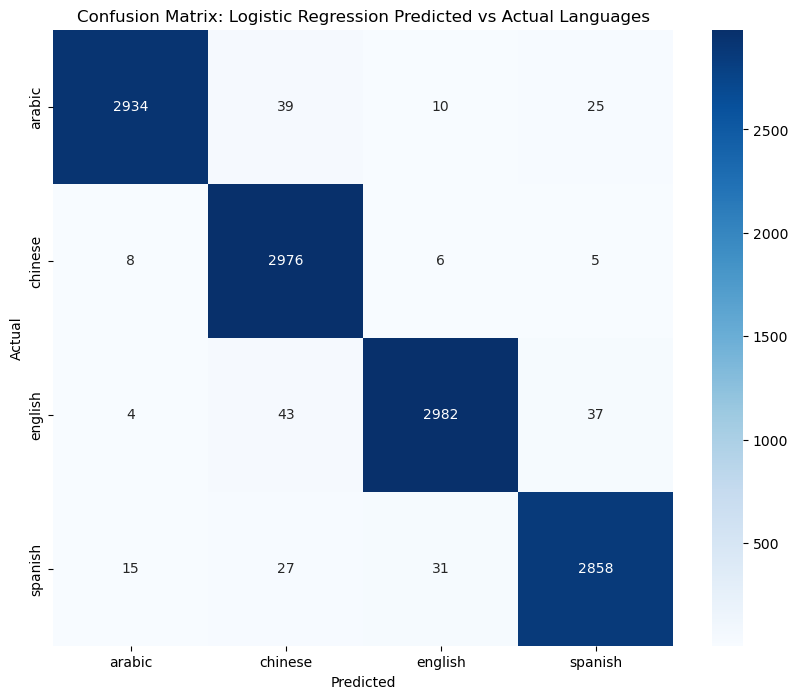

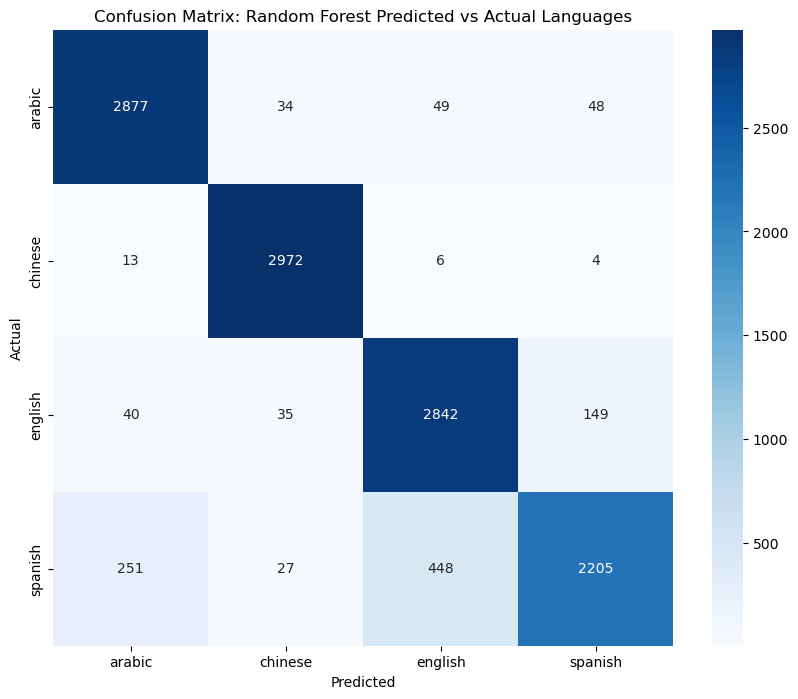

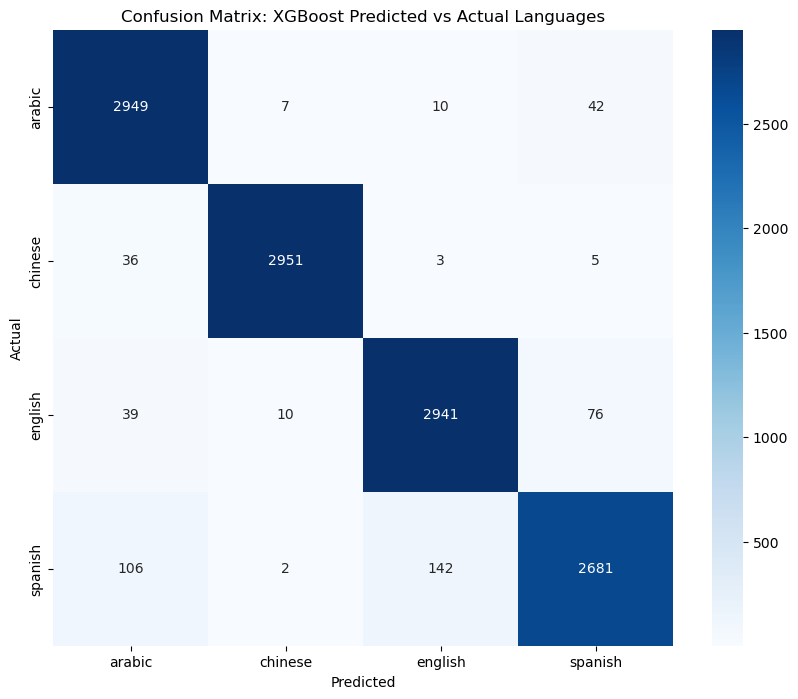

In [73]:
# Display confusion matrices
conf_matrix_logreg = confusion_matrix(y_test, y_test_pred_logreg)
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Logistic Regression Predicted vs Actual Languages')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest Predicted vs Actual Languages')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: XGBoost Predicted vs Actual Languages')
plt.show()

### Confusion Matrix Analysis

#### Confusion Matrix: Logistic Regression Predicted vs Actual Languages

- **Arabic**: Predicted correctly most of the time, with few misclassifications as Chinese and Spanish.
- **Chinese**: Very high accuracy, minimal misclassifications.
- **English**: High accuracy, but some confusion with Chinese and Spanish.
- **Spanish**: High accuracy, but more misclassifications compared to other languages, mainly confused with Arabic and English.

#### Confusion Matrix: Random Forest Predicted vs Actual Languages

- **Arabic**: High accuracy, though with more misclassifications compared to Logistic Regression.
- **Chinese**: Very high accuracy, almost no misclassifications.
- **English**: Lower accuracy compared to Logistic Regression, with notable misclassifications as Spanish.
- **Spanish**: Lower accuracy, significant misclassifications as Arabic and English.

#### Confusion Matrix: XGBoost Predicted vs Actual Languages

- **Arabic**: High accuracy, with few misclassifications as Chinese and Spanish.
- **Chinese**: Very high accuracy, minimal misclassifications.
- **English**: High accuracy, with some misclassifications as Chinese and Spanish.
- **Spanish**: High accuracy, but with some misclassifications as Arabic and English.

#### Summary
- Logistic Regression and XGBoost show high accuracy in classifying languages, with XGBoost slightly outperforming Logistic Regression.
- Random Forest, while still performing well, has more misclassifications, particularly confusing Spanish with Arabic and English.
- Chinese is the most accurately predicted language across all models, while Spanish shows the most misclassifications.



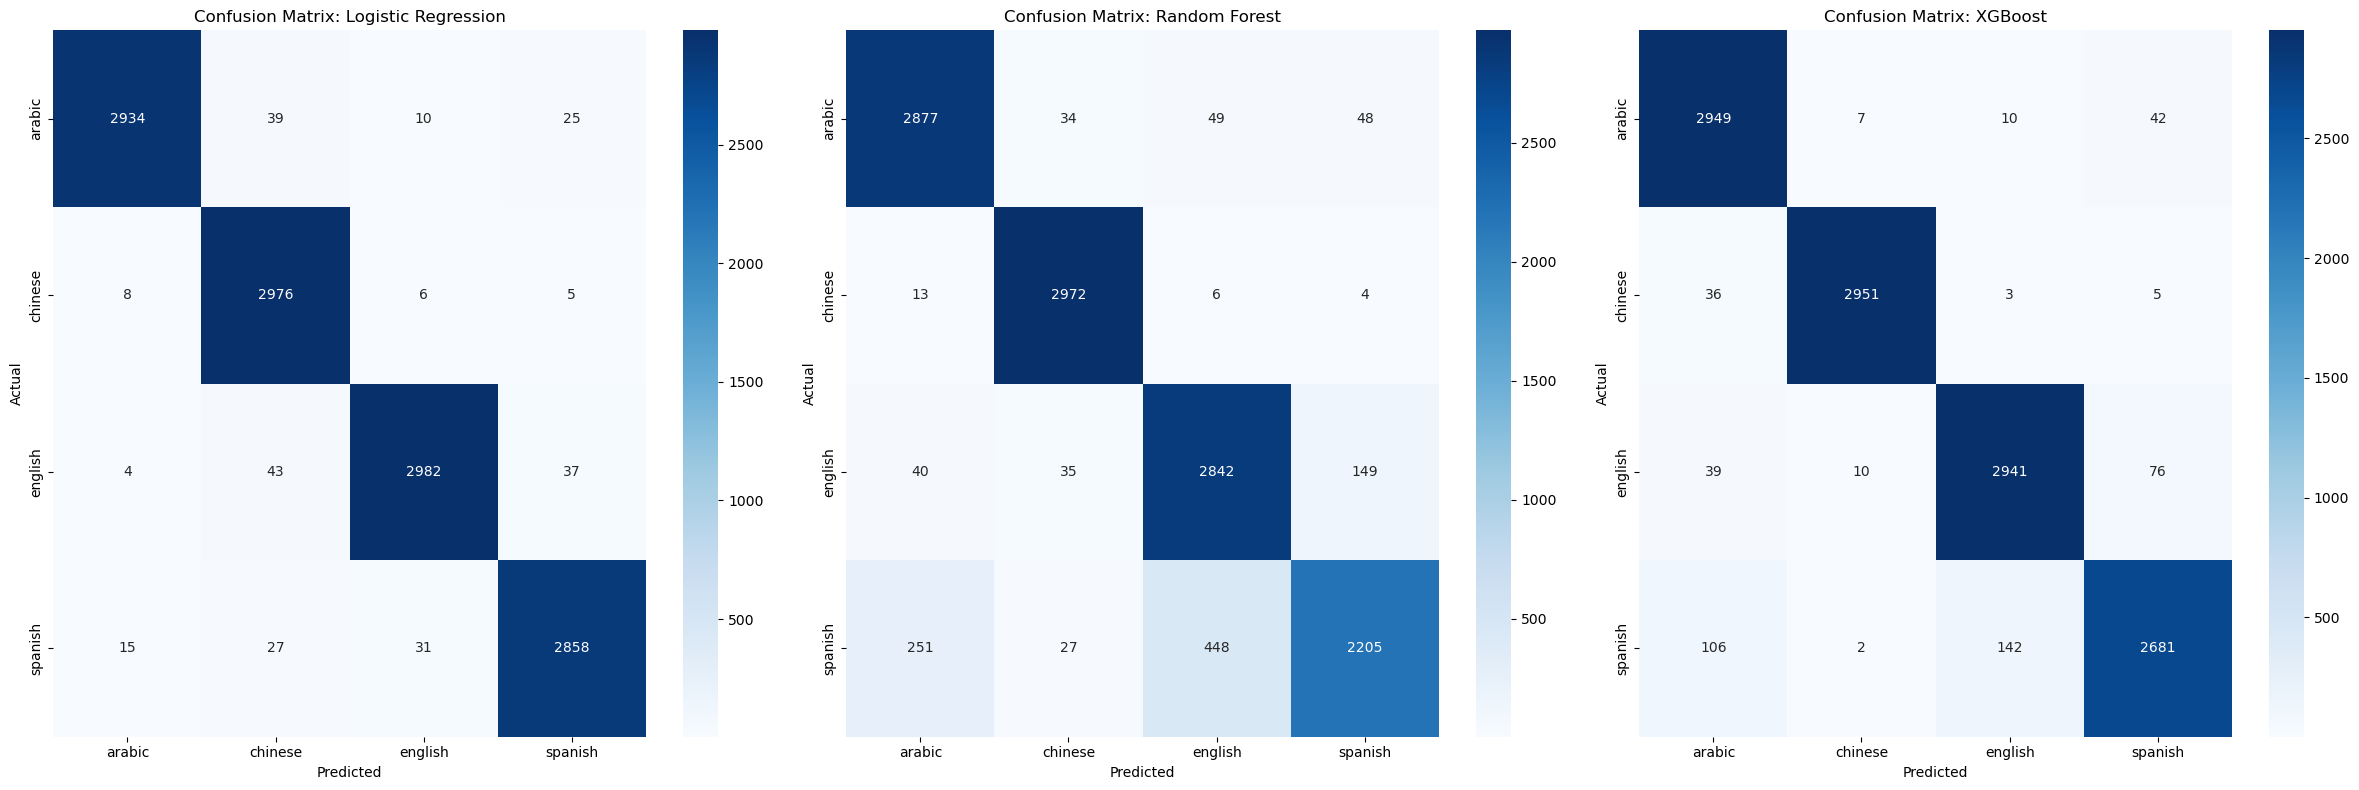

In [74]:
# Generate confusion matrices
conf_matrix_logreg = confusion_matrix(y_test, y_test_pred_logreg)
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Plot Logistic Regression confusion matrix
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Confusion Matrix: Logistic Regression')

# Plot Random Forest confusion matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Confusion Matrix: Random Forest')

# Plot XGBoost confusion matrix
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axs[2])
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('Actual')
axs[2].set_title('Confusion Matrix: XGBoost')

# Adjust layout
plt.tight_layout()
plt.show()

In [75]:
# Display predicted vs actual languages in a DataFrame
pred_vs_actual_logreg = pd.DataFrame({'Actual': label_encoder.inverse_transform(y_test), 'Predicted': label_encoder.inverse_transform(y_test_pred_logreg)})
pred_vs_actual_rf = pd.DataFrame({'Actual': label_encoder.inverse_transform(y_test), 'Predicted': label_encoder.inverse_transform(y_test_pred_rf)})
pred_vs_actual_xgb = pd.DataFrame({'Actual': label_encoder.inverse_transform(y_test), 'Predicted': label_encoder.inverse_transform(y_test_pred_xgb)})

print(pred_vs_actual_logreg.head(10))
print(pred_vs_actual_rf.head(10))
print(pred_vs_actual_xgb.head(10))

    Actual Predicted
0   arabic    arabic
1  spanish   spanish
2  chinese   chinese
3  english   english
4  chinese   chinese
5   arabic    arabic
6  spanish   spanish
7  chinese   chinese
8  spanish   spanish
9   arabic    arabic
    Actual Predicted
0   arabic    arabic
1  spanish   english
2  chinese   chinese
3  english   english
4  chinese   chinese
5   arabic    arabic
6  spanish   spanish
7  chinese   chinese
8  spanish   spanish
9   arabic    arabic
    Actual Predicted
0   arabic    arabic
1  spanish   english
2  chinese   chinese
3  english   english
4  chinese   chinese
5   arabic    arabic
6  spanish   spanish
7  chinese   chinese
8  spanish   spanish
9   arabic    arabic


Here I displaying the predicted vs actual languages in a DataFrame for each model. As can be seen our models seem to be preforming well predicting the actual languages very well.

In [76]:
# Randomly sample 10 elements from the dataset
sample_indices = np.random.choice(len(X_test), 10, replace=False)
X_sample = X_test[sample_indices]
y_sample = y_test[sample_indices]

We are getting a random sample of 10 elements from the test dataset. This is done so we can compare the predicted vs actual languages for each model.

In [77]:
# Use the loaded models to make predictions on the sampled data
y_sample_pred_logreg = loaded_model_logreg.predict(X_sample)
y_sample_pred_rf = loaded_model_rf.predict(X_sample)
y_sample_pred_xgb = loaded_model_xgb.predict(X_sample)

We are using the loaded models to make predictions on the sampled data.

In [78]:
# Display the predicted vs actual labels for Logistic Regression
pred_vs_actual_sample_logreg = pd.DataFrame({
    'Actual': label_encoder.inverse_transform(y_sample),
    'Predicted': label_encoder.inverse_transform(y_sample_pred_logreg)
})

# Display the predicted vs actual labels for Random Forest
pred_vs_actual_sample_rf = pd.DataFrame({
    'Actual': label_encoder.inverse_transform(y_sample),
    'Predicted': label_encoder.inverse_transform(y_sample_pred_rf)
})

# Display the predicted vs actual labels for XGBoost
pred_vs_actual_sample_xgb = pd.DataFrame({
    'Actual': label_encoder.inverse_transform(y_sample),
    'Predicted': label_encoder.inverse_transform(y_sample_pred_xgb)
})

print(pred_vs_actual_sample_logreg)
print(pred_vs_actual_sample_rf)
print(pred_vs_actual_sample_xgb)

    Actual Predicted
0  spanish   spanish
1  spanish   spanish
2  english   english
3  spanish   spanish
4  english   english
5  english   english
6  spanish   spanish
7  chinese   chinese
8   arabic    arabic
9   arabic    arabic
    Actual Predicted
0  spanish   spanish
1  spanish   spanish
2  english   english
3  spanish   spanish
4  english   english
5  english   english
6  spanish    arabic
7  chinese   chinese
8   arabic    arabic
9   arabic    arabic
    Actual Predicted
0  spanish   spanish
1  spanish   spanish
2  english   english
3  spanish   spanish
4  english   english
5  english   english
6  spanish   spanish
7  chinese   chinese
8   arabic    arabic
9   arabic   spanish


This section displays the comparison between the actual and predicted labels for the Logistic Regression, Random Forest, and XGBoost models using a sample of 10 random elements from the dataset.

## 7. KMeans Clustering
To further explore the structure of the data, we apply KMeans clustering to the PCA-transformed data. The optimal number of clusters is determined using the elbow method and silhouette scores.

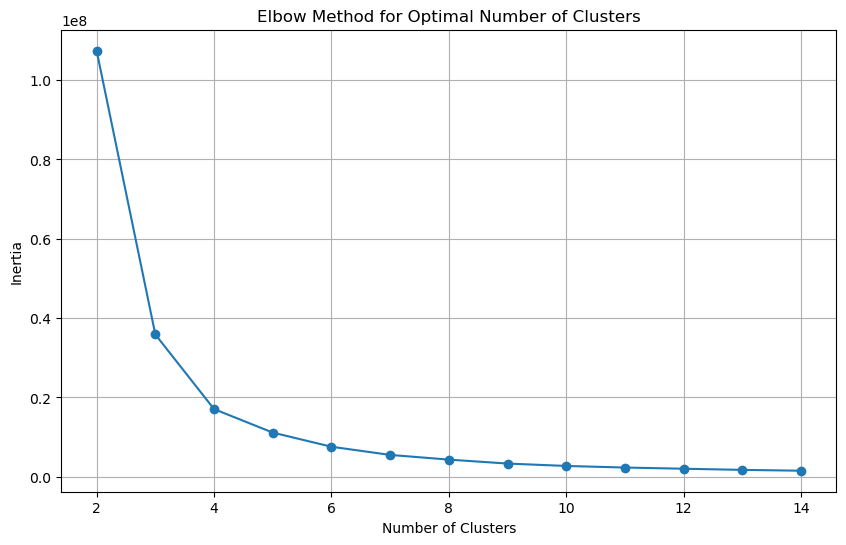

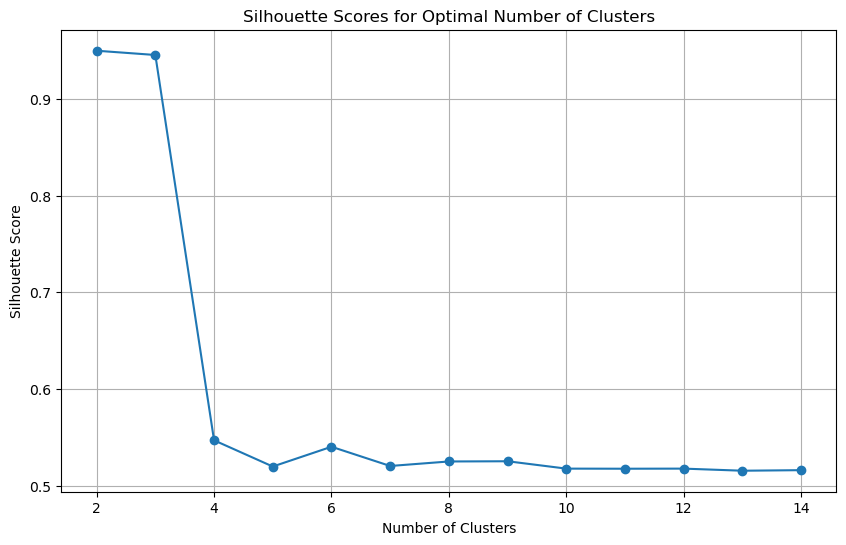

In [79]:
# Optimize KMeans Clustering
from sklearn.metrics import silhouette_score

inertia = []
silhouette_scores = []
range_n_clusters = range(2, 15)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(principal_components)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(principal_components, kmeans.labels_))

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.grid()
plt.show()

### Optimizing KMeans Clustering

We optimize KMeans clustering to find the best number of clusters using inertia and silhouette scores.

**Inertia:**
- Measures cluster tightness (within-cluster sum of squares).
- Lower values indicate better compactness within clusters.
- Use the "elbow method" to find the optimal number of clusters.

**Silhouette Score:**
- Measures how well clusters are separated.
- Ranges from -1 to 1, with higher values indicating better-defined clusters.

In [80]:
# Apply KMeans with the optimal number of clusters
optimal_n_clusters = 4  # Based on both elbow and silhouette score methods
print(f"Optimal number of clusters: {optimal_n_clusters}")

kmeans_optimized = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
kmeans_labels_optimized = kmeans_optimized.fit_predict(principal_components)

Optimal number of clusters: 4


Here I am applying KMeans clustering with the optimal number of clusters. The optimal number of clusters is determined based on both the elbow method and silhouette score methods. Which I found to be 4.

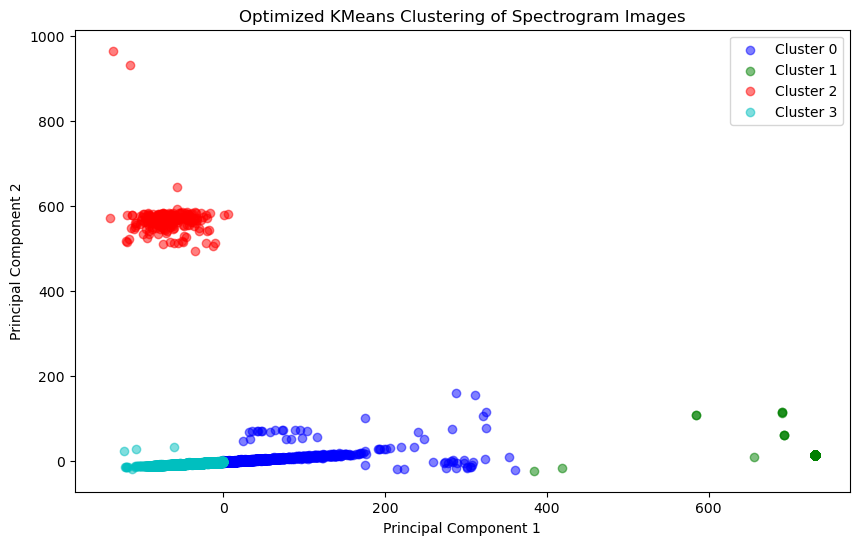

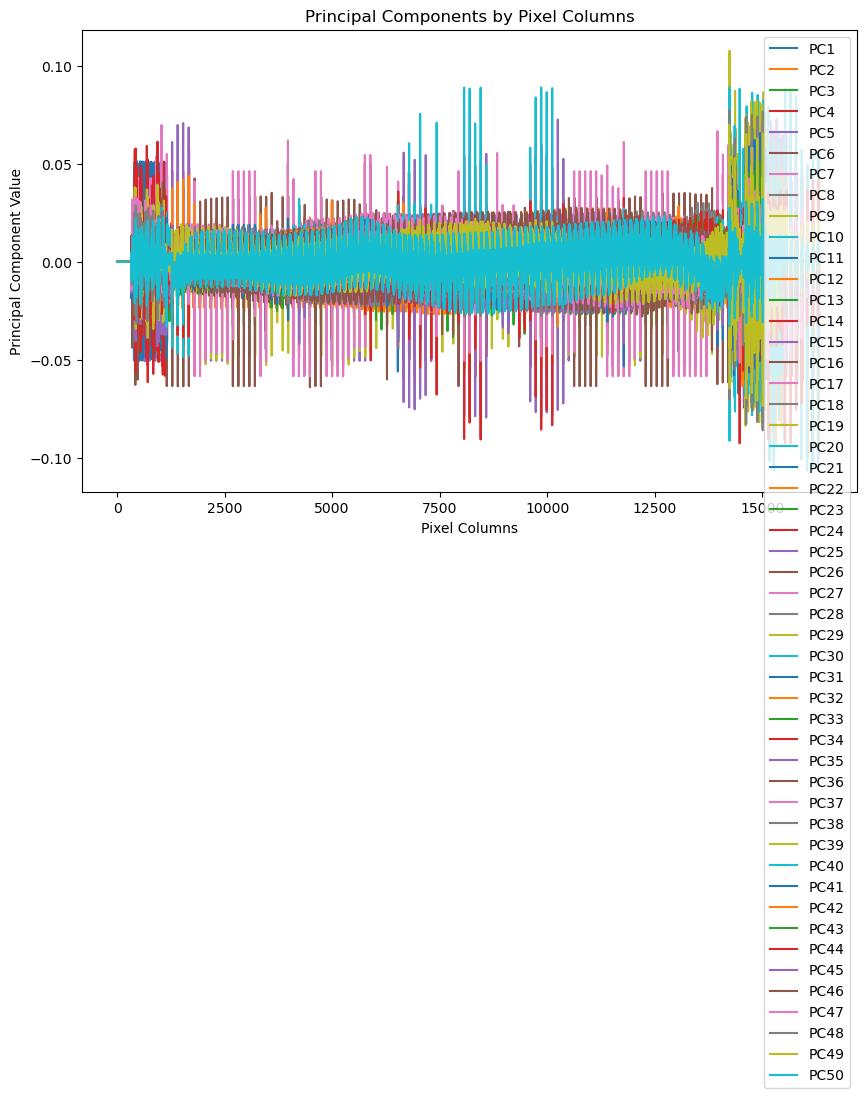

In [81]:
# Plot KMeans clustering results
plt.figure(figsize=(10, 6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for i, color in zip(range(optimal_n_clusters), colors):
    indices = kmeans_labels_optimized == i
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1], color=color, alpha=0.5, label=f'Cluster {i}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Optimized KMeans Clustering of Spectrogram Images')
plt.legend()
plt.show()

# Plot which principal components encompass which pixel columns
pca_components = pca.components_
plt.figure(figsize=(10, 6))
for i in range(n_components):
    plt.plot(pca_components[i], label=f'PC{i+1}')
plt.xlabel('Pixel Columns')
plt.ylabel('Principal Component Value')
plt.title('Principal Components by Pixel Columns')
plt.legend()
plt.show()

#### Code Explanation

1. **KMeans Clustering Results Plot:**
   - The code creates a scatter plot to visualize the clustering of spectrogram images using optimized KMeans.
   - It uses a cycle of colors to differentiate between clusters.
   - The clusters are plotted based on their principal components.

2. **Principal Components by Pixel Columns Plot:**
   - This plot shows how each principal component is related to the pixel columns.
   - It helps in understanding which pixels contribute most to each principal component.

#### Graphs Explanation

1. **Optimized KMeans Clustering of Spectrogram Images:**
   - **Graph:** The scatter plot shows the spectrogram images clustered into distinct groups.
   - **Insight:** The principal components separate the clusters clearly, indicating effective clustering.
   - **Clusters:** Each color represents a different cluster, labeled from 0 to 3.

2. **Principal Components by Pixel Columns:**
   - **Graph:** This line plot shows the value of each principal component across the pixel columns.
   - **Insight:** It reveals the contribution of each pixel to the principal components.
   - **Components:** Each line represents a different principal component, showing the variation in pixel importance.

## 8. Feature Importance Analysis
For the Random Forest and XGBoost models, we analyze the feature importance to identify which features (pixels in the spectrogram images) contribute most significantly to the model's predictions.

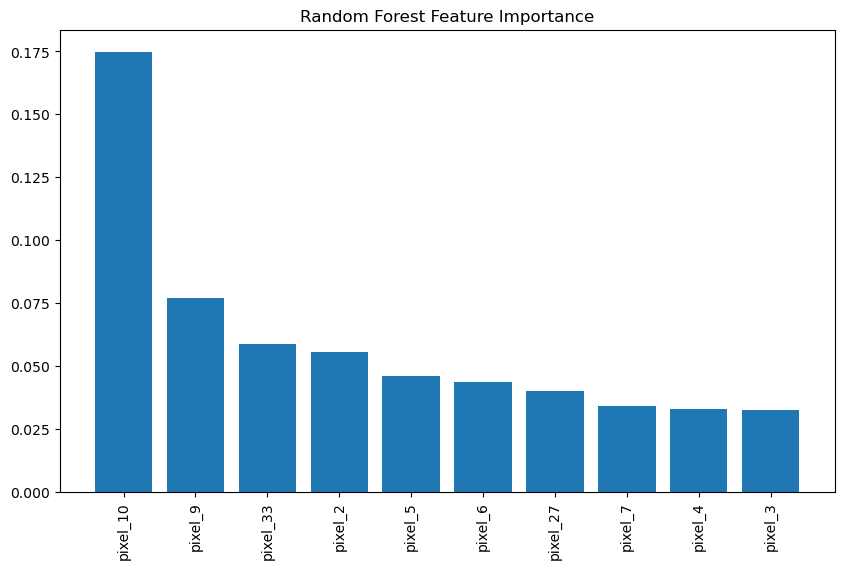

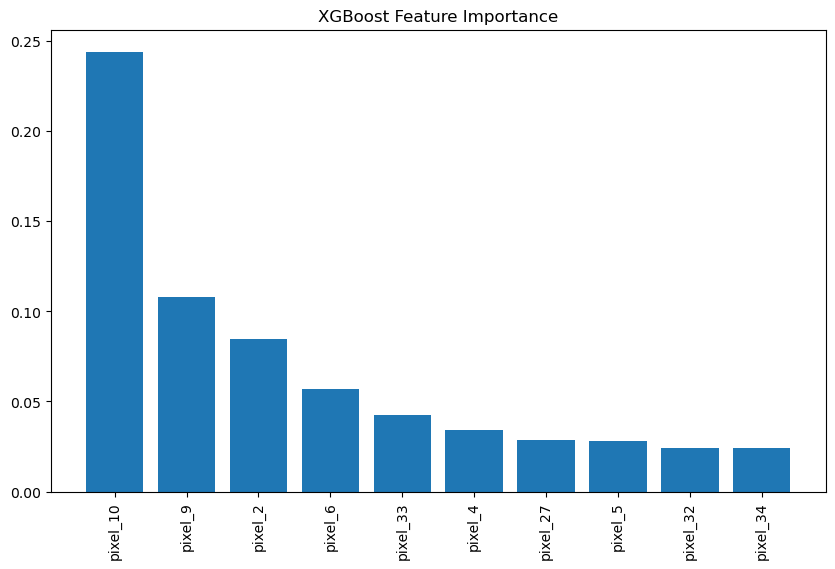

In [82]:
# Feature importance for Random Forest
feature_importances_rf = best_model_rf.named_steps['rf'].feature_importances_
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance")
plt.bar(range(len(sorted_idx_rf[:10])), feature_importances_rf[sorted_idx_rf[:10]], align='center')
plt.xticks(range(len(sorted_idx_rf[:10])), np.array(df.columns[:-1])[sorted_idx_rf[:10]], rotation=90)
plt.show()

# Feature importance for XGBoost
feature_importances_xgb = best_model_xgb.named_steps['xgb'].feature_importances_
sorted_idx_xgb = np.argsort(feature_importances_xgb)[::-1]
plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importance")
plt.bar(range(len(sorted_idx_xgb[:10])), feature_importances_xgb[sorted_idx_xgb[:10]], align='center')
plt.xticks(range(len(sorted_idx_xgb[:10])), np.array(df.columns[:-1])[sorted_idx_xgb[:10]], rotation=90)
plt.show()

In this code we are trying to extract the feature importance for the Random Forest and XGBoost models. We are using the best model from the grid search to extract the feature importance.

#### Random Forest Feature Importance

The feature importance plot for the Random Forest model shows which pixels contribute the most to the model's decision-making process. Here, the top 10 most important features are highlighted, with `pixel_10` being the most significant. Understanding which features are most important can help in interpreting the model and identifying key parts of the spectrogram images that the model relies on for language detection.

#### XGBoost Feature Importance

The feature importance plot for the XGBoost model similarly highlights the most influential pixels in the decision-making process. The top 10 most important features are shown, with the most significant feature being `pixel_10` as well. This analysis helps in understanding how the XGBoost model prioritizes different parts of the spectrogram images for accurate language detection.

## 9. Predictions on New Data
Finally, we load a new dataset of spectrogram images and make predictions using the trained models. The results are evaluated to ensure the models' robustness and generalizability to unseen data.

In [83]:
# Load the new CSV file for additional predictions
csv_file_new = '../data/spectrogram_flattend_image_next_10000_data.csv'
data_new = pd.read_csv(csv_file_new)

Here I am loading a new CSV file containing spectrogram images of 10,000 randomly selected data.

In [84]:
# Extract unique languages
languages_new = data_new['language'].unique()

I am extracting the unique languages from the new dataset. This will be used to select 10 random samples for each language.

In [85]:
# Placeholder for selected random samples
random_samples_new = []

# Select 10 random samples for each language
for language in languages_new:
    language_data = data_new[data_new['language'] == language]
    random_samples_new.append(language_data.sample(n=10, random_state=42))
# Concatenate the samples into a single DataFrame
random_samples_df_new = pd.concat(random_samples_new)

random_samples_df_new = random_samples_df_new.sample(frac=1, random_state=42).reset_index(drop=True)

I am concatenating the samples into a single DataFrame and shuffling the rows. This is done to ensure the same random samples are used for each model.

In [86]:
# Assuming the 'language' column is the target and the rest are features
X_new = random_samples_df_new.drop('language', axis=1)
y_new = random_samples_df_new['language']

In [87]:
# Label encode the target variable (languages)
y_new_encoded = label_encoder.fit_transform(y_new)

# Normalize the features using StandardScaler
X_new_scaled = scaler.transform(X_new)

/opt/anaconda3/envs/audio_processing/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


I am label encoding the target variable (languages) and normalizing the features using StandardScaler.

In [88]:
# Make predictions using Logistic Regression model
predictions_new_logreg = loaded_model_logreg.predict(X_new_scaled)
# Make predictions using Random Forest model
predictions_new_rf = loaded_model_rf.predict(X_new_scaled)
# Make predictions using XGBoost model
predictions_new_xgb = loaded_model_xgb.predict(X_new_scaled)

In this code I am making predictions using the Logistic Regression, Random Forest, and XGBoost models on the new dataset.

In [89]:
# Decode the predictions back to original language labels for Logistic Regression
predictions_new_logreg_decoded = label_encoder.inverse_transform(predictions_new_logreg)
# Decode the predictions back to original language labels for Random Forest
predictions_new_rf_decoded = label_encoder.inverse_transform(predictions_new_rf)
# Decode the predictions back to original language labels for XGBoost
predictions_new_xgb_decoded = label_encoder.inverse_transform(predictions_new_xgb)

In these lines I am decoding the predictions back to original language labels. This is done to compare the predictions with the actual labels.

In [90]:
# Create a DataFrame to show the results for Logistic Regression
results_new_logreg = pd.DataFrame({
    'Actual': y_new.values,
    'Predicted': predictions_new_logreg_decoded
})

# Create a DataFrame to show the results for Random Forest
results_new_rf = pd.DataFrame({
    'Actual': y_new.values,
    'Predicted': predictions_new_rf_decoded
})

# Create a DataFrame to show the results for XGBoost
results_new_xgb = pd.DataFrame({
    'Actual': y_new.values,
    'Predicted': predictions_new_xgb_decoded
})

print(results_new_logreg)
print(results_new_rf)
print(results_new_xgb)

     Actual Predicted
0   spanish   spanish
1   spanish   spanish
2   spanish   spanish
3   chinese   chinese
4   english   english
5   spanish   spanish
6    arabic    arabic
7   chinese   chinese
8    arabic    arabic
9   english   english
10  chinese   chinese
11  english   english
12  spanish   spanish
13   arabic    arabic
14   arabic    arabic
15  english   english
16  spanish   spanish
17  chinese   chinese
18  english   english
19   arabic    arabic
20  english   english
21  spanish   spanish
22  english   english
23  chinese   chinese
24  chinese   chinese
25  english   english
26   arabic    arabic
27   arabic    arabic
28  english   english
29   arabic    arabic
30  chinese   chinese
31   arabic    arabic
32  spanish   spanish
33  chinese   chinese
34  spanish   spanish
35  chinese   chinese
36  english   spanish
37  spanish   spanish
38  chinese   chinese
39   arabic    arabic
     Actual Predicted
0   spanish   spanish
1   spanish   spanish
2   spanish    arabic
3   chines

Copy code
## Conclusion

In this project, we successfully developed a robust language detection system capable of accurately identifying the language spoken in audio recordings and generating corresponding subtitles. Our systematic approach encompassed several crucial steps, from data collection and preparation to model training and evaluation, ensuring the creation of a reliable and efficient system.

### Key Achievements

1. **Data Collection and Preparation**: We gathered a balanced dataset of audio recordings in multiple languages, converting them into spectrogram images for further analysis.

2. **Data Visualization**: By visualizing the first and mean spectrogram images and analyzing pixel intensity distributions, we gained valuable insights into the unique patterns of each language.

3. **Data Preprocessing**: We effectively encoded language labels, split the data into training and testing sets, and standardized the spectrogram image data.

4. **Principal Component Analysis (PCA)**: PCA enabled us to reduce data dimensionality while retaining essential features, facilitating visualization and analysis of language separability.

5. **Model Training and Evaluation**: We trained and evaluated multiple models, including Logistic Regression, Random Forest, and XGBoost. The Logistic Regression and XGBoost models demonstrated superior performance with high accuracy and balanced metrics.

6. **Model Comparison and Selection**: By comparing model performance, we identified the best-performing models and saved them for future use.

7. **KMeans Clustering**: Applying KMeans clustering helped us explore the data structure and validate the effectiveness of our clustering approach.

8. **Feature Importance Analysis**: We analyzed feature importance for Random Forest and XGBoost models, identifying significant pixels in the spectrogram images that contributed to model predictions.

9. **Predictions on New Data**: Evaluating our models on new data ensured their robustness and generalizability to unseen datasets.

### Impact

Our language detection system has the potential to significantly enhance the accessibility and usability of multimedia content across various languages and regions. By automatically generating accurate subtitles, we can improve access to entertainment, education, and professional content for non-native speakers, supporting linguistic diversity and inclusivity.

### Future Work

- **Data Augmentation**: Explore data augmentation techniques and implement Convolutional Neural Networks (CNNs) to further improve model robustness and accuracy.
- **Additional Languages**: Expand the dataset to include more languages, enhancing the system's versatility.
- **Real-time Processing**: Implement real-time language detection and subtitle generation for live audio streams.
- **Deployment**: Develop a user-friendly application to deploy the system for end-users in various industries.

In conclusion, our project demonstrates the feasibility and effectiveness of using spectrogram images and machine learning techniques for language detection. The comprehensive workflow and systematic approach ensure a reliable and efficient solution, paving the way for future advancements in multilingual subtitle generation.
